In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from glob import glob
from sklearn.preprocessing import StandardScaler

np.random.seed(1)
pd.set_option('display.max_columns', None)
pd.set_option('precision', 4)

In [2]:
filenames = glob('results_ploss*.csv') + ['results_lambdas_grid.csv', ]

In [3]:
filenames

['results_ploss_runs.csv',
 'results_ploss_runs2.csv',
 'results_lambdas_grid.csv']

In [4]:
df = pd.read_csv(filenames[0])

for filename in filenames[1:]:
    df = df.append(pd.read_csv(filename))
    
df = df.drop(columns=['Unnamed: 0'])

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,4356.0,1757.0475,1189.7060,0.0000e+00,6.2075e+02,1709.5000,2798.2500,3887.0000
number_hidden_layers,4356.0,4.1074,0.9943,3.0000e+00,3.0000e+00,5.0000,5.0000,5.0000
number_hidden_nodes,4356.0,121.9174,83.2435,3.2000e+01,6.4000e+01,128.0000,128.0000,512.0000
dropout,4356.0,0.1327,0.1151,1.0000e-02,1.0000e-02,0.1000,0.3000,0.3000
learning_rate,4356.0,0.0004,0.0005,1.0000e-05,1.0000e-05,0.0001,0.0010,0.0010
test_fraction,4356.0,0.1169,0.0746,5.0000e-02,5.0000e-02,0.0500,0.2000,0.2000
epochs_a,4356.0,52.9752,34.8032,1.0000e+01,1.0000e+01,50.0000,100.0000,100.0000
epochs_b,4356.0,58.3471,37.6707,1.0000e+01,1.0000e+01,50.0000,100.0000,100.0000
elapsed_time,4125.0,379.0169,321.6266,4.3711e+01,6.4742e+01,294.9262,554.2863,2367.3758
training_nn_loss,4125.0,0.6351,0.1800,0.0000e+00,4.9704e-01,0.5877,0.7319,1.0104


In [15]:
df['combined_loss'] = np.sqrt(np.power(df.training_loss, 2) + np.power(df.validation_loss, 2))
df['loss_diff_abs'] = np.absolute(df.training_loss - df.validation_loss)
df['loss_diff'] = df.training_loss - df.validation_loss
df['loss_pct'] = np.absolute(df.training_loss - df.validation_loss) / df.training_loss
df['combined_loss_diff'] = np.sqrt(np.power(df.training_loss, 2) + np.power(df.validation_loss, 2)) + df.loss_diff

In [17]:
loss_weights_a = []
loss_weights_b = []

for loss_weight in df['loss_weights_b'].values:
    loss_weight_split = loss_weight.split(',')
    loss_weight_a, loss_weight_b = loss_weight_split

    loss_weights_a.append(float(loss_weight_a.replace('[', '')))
    loss_weights_b.append(float(loss_weight_b.replace(']', '')))

df['loss_weight_a'] = loss_weights_a
df['loss_weight_b'] = loss_weights_b

In [18]:
regressors = ['number_hidden_layers', 'number_hidden_nodes', 'dropout', 'learning_rate', 'test_fraction', 'loss_weight_a', 'loss_weight_b', 'epochs_a', 'epochs_b', 'n_batch']
responses = ['training_nn_loss', 'validation_nn_loss', 'training_p_loss', 'validation_p_loss', 'training_loss', 'validation_loss', 'loss_diff', 'combined_loss_diff']

In [20]:
regressors = {'number_hidden_layers': {'label': 'Number Hidden Layers'},
               'number_hidden_nodes': {'label': 'Number Hidden Nodes'},
               'dropout': {'label': 'Dropout Rate'},
               'learning_rate': {'label': 'Learning Rate'},
               'test_fraction': {'label': 'Test Fraction'},
               'loss_weight_a': {'label': 'NN Loss Weight'},
               'loss_weight_b': {'label': 'Physics Loss Weight'},
               'epochs_a': {'label': 'Base Training Epochs'},
               'epochs_b': {'label': 'Physics Training Epochs'},
               'n_batch': {'label': 'Batch Size'}
              }

responses = {'training_loss': {'title': 'Training Loss', 'unit': 'Mean Absolute Error'},
             'validation_loss': {'title': 'Validation Loss', 'unit': 'Mean Absolute Error'},
             'loss_diff': {'title': 'Loss Difference (Training - Validation)', 'unit': 'Mean Absolute Error'},
             'training_p_loss': {'title': 'Training Physics Function Loss', 'unit': 'Mean Absolute Error'},
             'validation_p_loss': {'title': 'Validation Physics Function Loss', 'unit': 'Mean Absolute Error'},
             'training_nn_loss': {'title': 'Training NN Loss', 'unit': 'Mean Absolute Error'},
             'validation_nn_loss': {'title': 'Validation NN Loss', 'unit': 'Mean Absolute Error'}
            }

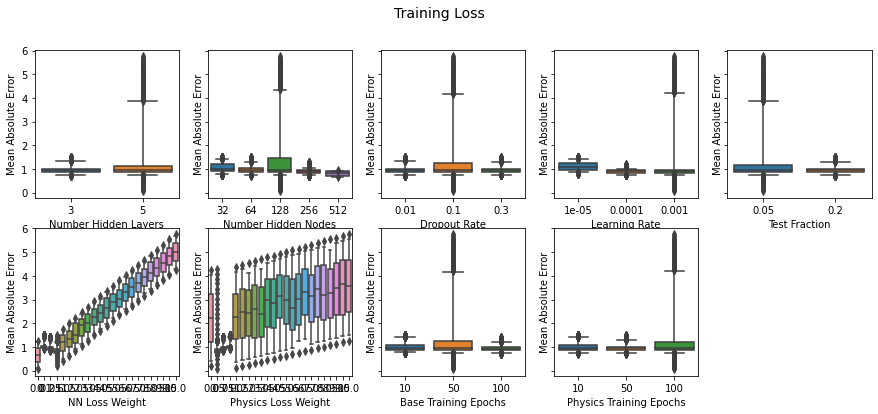

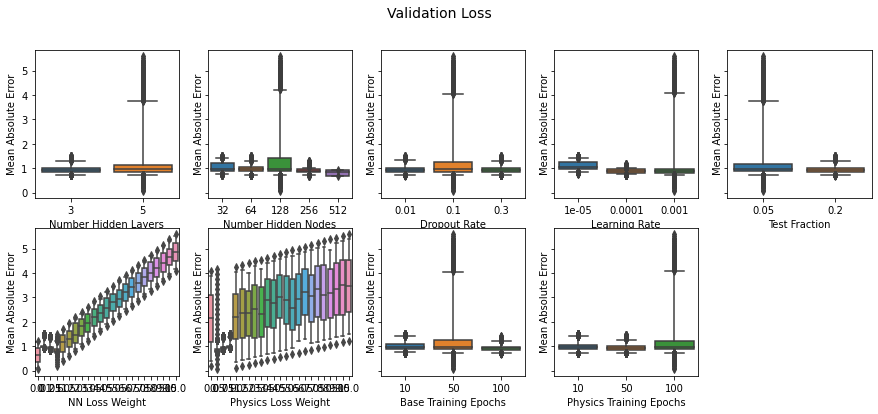

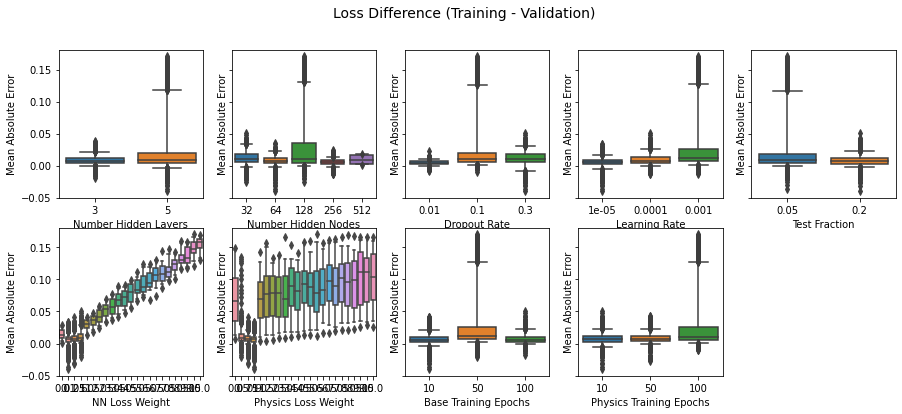

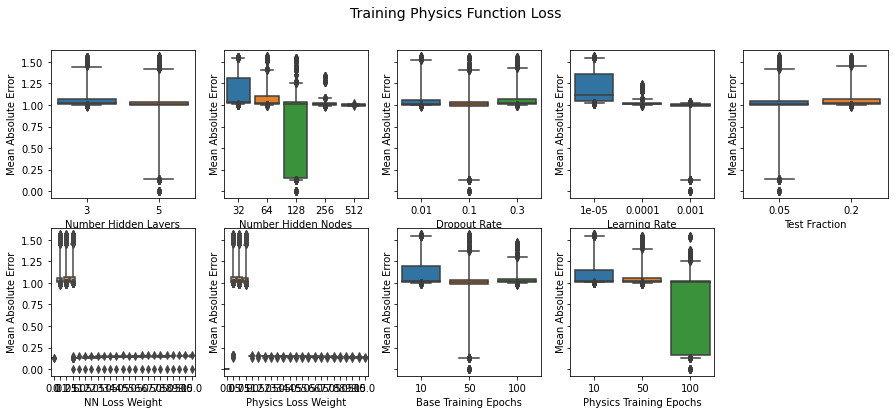

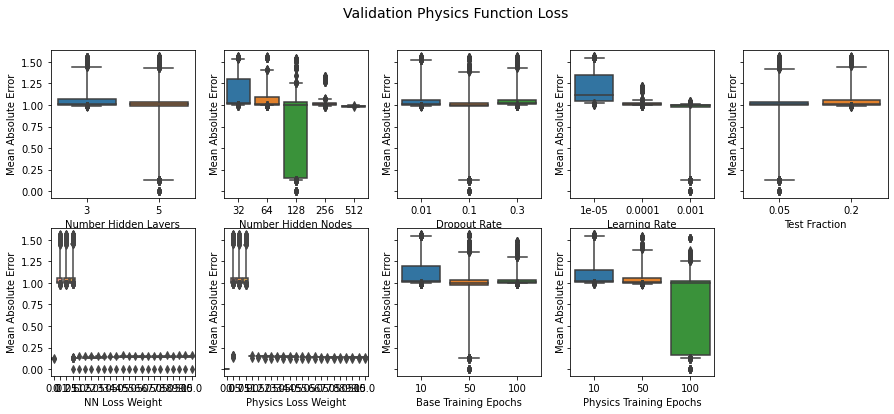

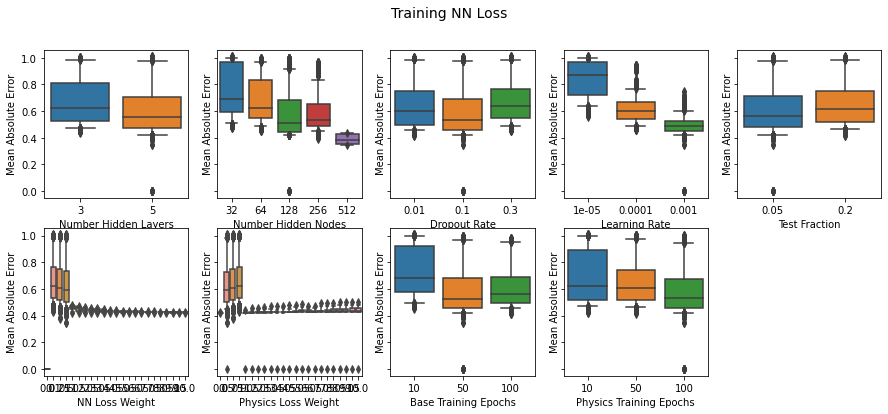

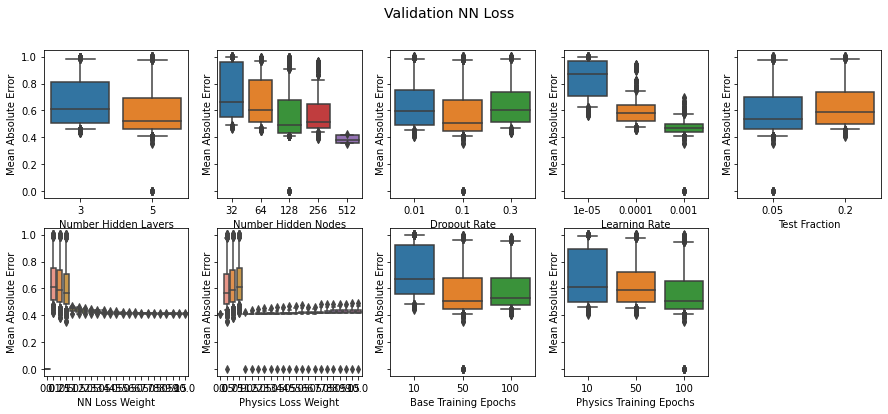

In [22]:
for response in responses.keys():
    fig, axs = plt.subplots(nrows=2, ncols=5, sharey=True, figsize=(15, 6))
    fig.suptitle(responses[response]['title'], fontsize=14)
    axs = axs.flatten()
    for i, regressor in enumerate(regressors.keys()):
        _ax = sns.boxplot(data=df, x=regressor, y=response, whis=[5, 95], ax=axs[i])
        _ax.set_xlabel(regressors[regressor]['label'])
        _ax.set_ylabel(responses[response]['unit'])
    fig.delaxes(axs[-1])

In [38]:
df.loc[non_zero_weights].dropna()[responses.keys()]

,training_loss,validation_loss,loss_diff,training_p_loss,validation_p_loss,training_nn_loss,validation_nn_loss
0,0.7263,0.7080,0.0183,1.0086,0.9932,0.4439,0.4227
1,0.7249,0.7050,0.0200,1.0174,0.9917,0.4325,0.4182
2,0.7269,0.7066,0.0203,1.0170,0.9992,0.4367,0.4140
3,0.8666,0.8520,0.0146,1.0020,0.9883,0.4605,0.4433
4,0.8714,0.8462,0.0251,1.0099,0.9820,0.4558,0.4390
...,...,...,...,...,...,...,...
436,5.4657,5.2969,0.1688,0.1470,0.1433,0.4289,0.4150
437,5.5420,5.3741,0.1679,0.1467,0.1431,0.4295,0.4158
438,5.6055,5.4444,0.1611,0.1468,0.1425,0.4285,0.4162
439,5.6852,5.5187,0.1665,0.1460,0.1422,0.4298,0.4168


In [49]:
df_reg = df.loc[(df['loss_weight_a'] != 0) & (df['loss_weight_b'] != 0) ].dropna()[responses.keys()]
df_reg['ones'] = np.ones_like(df_reg.index)

scaler = StandardScaler()

for regressor in regressors:
    df_reg[regressor] = scaler.fit_transform(df.loc[(df['loss_weight_a'] != 0) & (df['loss_weight_b'] != 0) ].dropna()[regressor].values.reshape(-1, 1))

In [50]:
ols_regressors = list(regressors.keys()) + ['ones', ]

ols_regressors = ['ones', 'loss_weight_a', 'loss_weight_b']

for response in responses:
    ols = sm.OLS(df_reg[response], df_reg[ols_regressors])
    ols_results = ols.fit()
    print(ols_results.summary())


                            OLS Regression Results                            
Dep. Variable:          training_loss   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.757e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:04:31   Log-Likelihood:                 202.19
No. Observations:                 393   AIC:                            -398.4
Df Residuals:                     390   BIC:                            -386.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ones              2.8852      0.007    393.896

In [15]:
history = pd.read_csv('clds_opt_675_training_history.csv')

Text(0, 0.5, 'MSE')

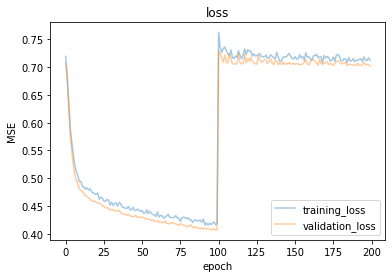

In [30]:

ax = history.sort_values('epoch')[['training_loss', 'validation_loss']].plot(alpha=0.4)
ax.set_title('loss')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE')

In [27]:
from glob import glob

In [28]:
filenames = glob('./optimization_results/*_training_history.csv')

Text(0, 0.5, 'MSE')

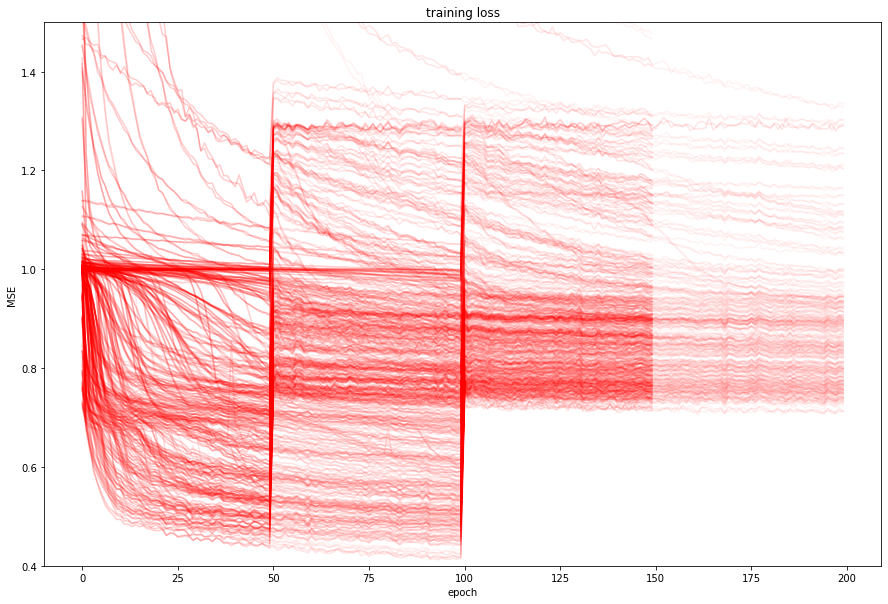

In [51]:
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.set_ylim(ymin=0.4, ymax=1.5)
for filename in filenames:
    history = pd.read_csv(filename)
    ax = history.sort_values('epoch')[['training_loss']].plot(alpha=0.05, ax=ax, legend=False, color='red')
ax.set_title('training loss')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE')

Text(0, 0.5, 'MSE')

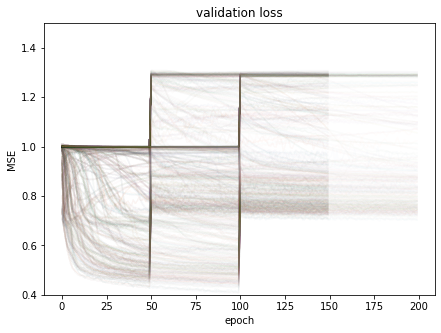

In [49]:
fig = plt.figure(figsize=(7, 5))
ax = fig.gca()
ax.set_ylim(ymin=0.4, ymax=1.5)
for filename in filenames:
    history = pd.read_csv(filename)
    ax = history.sort_values('epoch')[['validation_loss']].plot(alpha=0.01, ax=ax, legend=False)
ax.set_title('validation loss')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE')